In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm_notebook as tqdm
import sys
sys.path.append("../src/")
from logger import setup_logger, LOGGER
from trainer import train_lgbm
from util_tool import reduce_mem_usage
%matplotlib inline
from gensim.models import Word2Vec
pd.set_option('display.max_columns', 300)

In [2]:
# ==================
# Constant
# ==================
TRAIN_PATH = "../input/train.csv"
TEST_PATH = "../input/test.csv"
USER_PATH = "../input/user_x_anime.csv"

In [3]:
# =====================
# Settings
# =====================
SAVE_PATH = "../output/fe/fe015.feather"

In [4]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
user = pd.read_csv(USER_PATH)

In [5]:
user

,user_id,anime_id,rating,watching_status,watched_episodes
0,310366,11009,NaN,6,0
1,321597,4063,NaN,2,12
2,37696,114,9.0,2,26
3,316142,863,0.0,6,0
4,333376,32379,4.0,4,1
...,...,...,...,...,...
26992848,112800,617,NaN,2,1
26992849,34131,16498,NaN,2,25
26992850,110747,3927,8.0,2,25
26992851,94883,37497,NaN,4,6


In [8]:
def join(df):
    x = [str(e) for e in list(df)]
    return " ".join(x)
docs = user.groupby("user_id")["anime_id"].apply(join).reset_index()

In [9]:
docs

,user_id,anime_id
0,0,419 578 415 1689 433 1535 269 6098 2913 3418 2...
1,1,20 25777 37349 21881 35788 38691 38826 6547 40...
2,2,33231 35760 1389 24703 5762 5209 7875 14659 22...
3,3,306 31442 7593 13601 6880 33206 31764 19363 34...
4,4,578 1482 273 127 3470 7103 372 4725 105 819 15...
...,...,...
320135,353400,18679 18153 37349 43 10087 38691 40456 31240 3...
320136,353401,33255 33731 934 2216 10087 19 2356 10418 38000...
320137,353402,762 1142 121 1482 834 16 27 688 479 1579 68 1535
320138,353403,40221 36456 780 2966 10928 16397 31964 20507 1...


In [10]:
user_id_list = [i.split(" ") for i in docs["anime_id"]]

In [11]:
model = Word2Vec(user_id_list, vector_size=10, window=8, min_count=10, seed = 1,workers=6)

In [12]:
user_id_embedding = np.zeros((len(docs),model.vector_size))
vector_size = model.vector_size
for m,i in enumerate(tqdm(user_id_list)):
    embedding_ = np.zeros(vector_size)
    n = 0
    for t in i:
        try:
            embedding_ += model.wv[t]
            n += 1
        except KeyError:
            pass
    if n > 0:
        embedding_ /= n
    user_id_embedding[m,:] = embedding_

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/320140 [00:00<?, ?it/s]

In [22]:
anime_id_embedding = np.zeros((len(user),model.vector_size),dtype = np.float32)
vector_size = model.vector_size
for m,i in enumerate(tqdm(user["anime_id"])):
    embedding_ = np.zeros(vector_size)
    try:
        anime_id_embedding[m,:] = model.wv[str(i)]
    except KeyError:
        pass

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/26992853 [00:00<?, ?it/s]

In [18]:
df_user_id = pd.DataFrame(user_id_embedding)
df_user_id.columns = [f"user_id_emb_{i}" for i in range(10)]
df_user_id["user_id"] = docs["user_id"]
df_user_id = reduce_mem_usage(df_user_id)

Memory usage of dataframe is 26.87 MB
column =  11
0
Memory usage after optimization is: 13.43 MB
Decreased by 50.0%


In [19]:
df_user_id

,user_id_emb_0,user_id_emb_1,user_id_emb_2,user_id_emb_3,user_id_emb_4,user_id_emb_5,user_id_emb_6,user_id_emb_7,user_id_emb_8,user_id_emb_9,user_id
0,-2.967746,-1.531538,1.270567,-1.047011,1.230908,2.548359,1.117200,-0.548966,-0.821003,-0.375775,0
1,-3.318513,1.791686,-1.363168,-4.235212,-0.768384,-0.073247,-0.917018,3.061474,0.756200,-0.578450,1
2,1.842938,-1.238147,-2.815094,-0.920516,0.480280,-0.538248,-0.050486,1.531866,-0.236753,-2.546088,2
3,-0.932862,-0.553065,0.342497,-1.410857,1.427450,-1.279574,-1.776960,1.460238,2.604612,0.603675,3
4,-2.629179,-2.750639,1.851606,0.448578,2.124367,2.881729,-0.464953,-0.407811,-0.586183,0.721014,4
...,...,...,...,...,...,...,...,...,...,...,...
320135,-2.591776,0.793525,-1.376225,-4.328799,-0.299026,-1.301861,-0.363690,2.731031,0.884677,0.506802,353400
320136,-3.031655,-0.210322,-0.307901,-3.422218,0.368855,-0.799607,1.049007,1.255711,1.474126,-0.758528,353401
320137,-4.273852,-1.928373,1.407104,0.290824,2.945554,3.943800,-0.047638,-0.617890,-0.508395,-1.099671,353402
320138,-1.373971,1.443911,-0.215302,-1.370242,2.166212,-0.059914,-1.140540,1.209621,1.921243,0.864733,353403


In [23]:
df_anime_id = pd.DataFrame(anime_id_embedding)
df_anime_id.columns = [f"anime_id_emb_{i}" for i in range(10)]
df_anime_id["user_id"] = user["user_id"]
df_anime_id = reduce_mem_usage(df_anime_id)

Memory usage of dataframe is 1235.63 MB
column =  11
0
Memory usage after optimization is: 1132.67 MB
Decreased by 8.3%


In [25]:
anime_id_embedding[0]

array([ 3.0504003 ,  3.7912033 , -3.142626  , -0.30948526,  2.1567566 ,
        2.965756  ,  0.65724474, -0.698697  , -4.46843   , -0.79292154],
      dtype=float32)

In [26]:
df_anime_id = df_anime_id.merge(df_user_id, how="left", on ="user_id")

In [27]:
len(df_anime_id)

26992853

In [28]:
len(user)

26992853

In [31]:
user

,user_id,anime_id,rating,watching_status,watched_episodes
0,310366,11009,NaN,6,0
1,321597,4063,NaN,2,12
2,37696,114,9.0,2,26
3,316142,863,0.0,6,0
4,333376,32379,4.0,4,1
...,...,...,...,...,...
26992848,112800,617,NaN,2,1
26992849,34131,16498,NaN,2,25
26992850,110747,3927,8.0,2,25
26992851,94883,37497,NaN,4,6


In [33]:
df_anime_id["anime_id"] = user["anime_id"]
df_anime_id["rating"] = user["rating"]

In [34]:
df_train = df_anime_id[df_anime_id["rating"].notnull()].reset_index(drop=True)
df_test = df_anime_id[df_anime_id["rating"].isnull()].reset_index(drop=True)

In [35]:
drop_cols = ["user_id","anime_id","rating"]

,anime_id_emb_0,anime_id_emb_1,anime_id_emb_2,anime_id_emb_3,anime_id_emb_4,anime_id_emb_5,anime_id_emb_6,anime_id_emb_7,anime_id_emb_8,anime_id_emb_9,user_id,user_id_emb_0,user_id_emb_1,user_id_emb_2,user_id_emb_3,user_id_emb_4,user_id_emb_5,user_id_emb_6,user_id_emb_7,user_id_emb_8,user_id_emb_9,anime_id,rating
0,-2.195951,-3.772419,3.818226,-2.534633,1.462463,-2.061624,3.330819,-3.334679,0.089948,0.868145,37696,-0.373622,-0.356037,0.713853,-0.656107,-0.337510,-1.025926,-0.262039,0.782757,0.765712,0.264858,114,9.0
1,2.778959,-6.471229,2.573016,1.346067,1.983267,3.303484,-2.120680,-1.321846,-0.611202,0.609645,316142,-0.410157,0.167542,-0.179180,-0.059755,1.133275,-1.725890,-1.780657,1.477293,1.859989,0.177443,863,0.0
2,-3.647601,1.912744,-0.916663,-1.982340,-0.062876,-4.272185,1.863875,0.356601,1.191961,-3.857475,333376,-2.580769,0.752982,-0.161165,-1.203218,0.980057,-0.907624,-0.877481,1.536771,0.934196,0.560493,32379,4.0
3,1.648869,-4.170552,2.608114,4.265744,2.799742,2.629259,-4.811376,-0.451998,1.818901,-1.758572,233899,2.702374,-1.692312,-1.773741,0.425524,0.751871,-0.163410,-0.748316,1.039407,0.126474,-2.068528,1727,0.0
4,2.258849,1.107922,1.518982,2.835229,2.933023,2.565160,-1.851654,0.059301,3.348085,1.793498,303570,0.039172,0.608264,-0.441833,-1.687806,-0.343436,-0.611048,-1.969633,2.172866,1.739162,-0.479745,11313,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10202651,1.635281,-2.853780,3.818583,-1.957422,2.617669,6.376830,0.181694,-3.067531,1.276083,-1.337628,57328,-1.519533,-4.007287,2.512646,-1.635689,2.230100,1.860798,0.343006,-1.625050,0.789234,-1.029109,517,0.0
10202652,-2.976527,-1.173364,2.448493,-4.064868,0.309171,-3.669329,4.829303,-2.064344,1.946809,-0.159512,211190,-0.339847,-0.030794,-0.095792,-2.357295,0.132791,-1.296967,-0.777655,1.904837,2.240712,1.075582,6675,8.0
10202653,3.809021,-2.728712,-3.935431,1.072020,0.806420,-1.283342,0.660204,0.985487,-1.418998,-4.071331,219489,1.953499,-1.104317,0.314941,0.812227,0.752611,0.684887,0.320376,-0.799441,-0.731996,-1.252959,14129,0.0
10202654,3.280409,0.590959,-2.647098,-2.641187,4.479712,-0.676411,-4.648967,2.413895,5.464056,-1.786369,200868,-0.529572,-0.256689,0.651976,-1.530146,-0.259607,-0.551696,0.794024,0.444650,0.052147,1.120803,13663,5.0


In [62]:
df_test.head()

,anime_id_emb_0,anime_id_emb_1,anime_id_emb_2,anime_id_emb_3,anime_id_emb_4,anime_id_emb_5,anime_id_emb_6,anime_id_emb_7,anime_id_emb_8,anime_id_emb_9,user_id,user_id_emb_0,user_id_emb_1,user_id_emb_2,user_id_emb_3,user_id_emb_4,user_id_emb_5,user_id_emb_6,user_id_emb_7,user_id_emb_8,user_id_emb_9,anime_id,rating,pred
0,3.050400,3.791203,-3.142626,-0.309485,2.156757,2.965756,0.657245,-0.698697,-4.468430,-0.792922,310366,0.826982,-0.117450,0.834023,0.884972,0.583127,0.571777,0.633394,-0.765746,-0.727219,-0.132977,11009,NaN,-0.035109
1,0.540510,-3.149322,-0.627486,-0.810242,4.435406,0.865999,-4.926434,1.058275,4.149081,-4.174861,321597,-0.124971,0.071186,0.251112,-1.561809,0.421417,-1.158944,-1.584399,1.517798,2.275919,0.193538,4063,NaN,0.057009
2,3.674385,-2.079708,0.998462,-5.482532,-5.304859,-2.802124,-2.596064,3.318975,-0.215868,4.305176,140177,-1.587554,-1.494644,0.586447,-1.049753,1.622287,1.313150,0.175608,0.388781,0.799751,0.432952,37614,NaN,-0.018150
3,1.613972,-2.587465,0.649625,0.099140,4.289641,-0.153807,-2.231972,0.980446,4.857932,2.677984,11331,-1.522131,0.147133,-0.008408,-1.873487,-0.359173,-1.000114,-1.623745,2.401577,1.514685,0.914700,9379,NaN,-0.027209
4,2.356364,2.783639,-2.761275,-2.144967,5.133792,3.205160,1.138660,-2.778785,-5.391512,-0.107012,264778,-1.050981,0.815587,-0.438498,-1.637616,2.146768,-0.049645,-0.006243,0.147979,0.835634,-0.738462,1525,NaN,0.001879


In [63]:
df_train.head()

,anime_id_emb_0,anime_id_emb_1,anime_id_emb_2,anime_id_emb_3,anime_id_emb_4,anime_id_emb_5,anime_id_emb_6,anime_id_emb_7,anime_id_emb_8,anime_id_emb_9,user_id,user_id_emb_0,user_id_emb_1,user_id_emb_2,user_id_emb_3,user_id_emb_4,user_id_emb_5,user_id_emb_6,user_id_emb_7,user_id_emb_8,user_id_emb_9,anime_id,rating,pred
0,-2.195951,-3.772419,3.818226,-2.534633,1.462463,-2.061624,3.330819,-3.334679,0.089948,0.868145,37696,-0.373622,-0.356037,0.713853,-0.656107,-0.337510,-1.025926,-0.262039,0.782757,0.765712,0.264858,114,9.0,8.938406
1,2.778959,-6.471229,2.573016,1.346067,1.983267,3.303484,-2.120680,-1.321846,-0.611202,0.609645,316142,-0.410157,0.167542,-0.179180,-0.059755,1.133275,-1.725890,-1.780657,1.477293,1.859989,0.177443,863,0.0,0.058719
2,-3.647601,1.912744,-0.916663,-1.982340,-0.062876,-4.272185,1.863875,0.356601,1.191961,-3.857475,333376,-2.580769,0.752982,-0.161165,-1.203218,0.980057,-0.907624,-0.877481,1.536771,0.934196,0.560493,32379,4.0,4.086280
3,1.648869,-4.170552,2.608114,4.265744,2.799742,2.629259,-4.811376,-0.451998,1.818901,-1.758572,233899,2.702374,-1.692312,-1.773741,0.425524,0.751871,-0.163410,-0.748316,1.039407,0.126474,-2.068528,1727,0.0,0.001940
4,2.258849,1.107922,1.518982,2.835229,2.933023,2.565160,-1.851654,0.059301,3.348085,1.793498,303570,0.039172,0.608264,-0.441833,-1.687806,-0.343436,-0.611048,-1.969633,2.172866,1.739162,-0.479745,11313,0.0,0.013890


In [48]:
from sklearn.model_selection import GroupKFold
sys.path.append("../src/")
from logger import setup_logger, LOGGER
from trainer import train_lgbm
from sklearn.metrics import cohen_kappa_score, mean_squared_error

In [37]:
LOGGER_PATH = f"../output/fe/fe_015.txt"

In [42]:
# ====================
# Function
# ====================
from contextlib import contextmanager
import logging
import time
def calc_loss(y_true, y_pred):
    return  np.sqrt(mean_squared_error(y_true, y_pred))


@contextmanager
def timer(name):
    t0 = time.time()
    yield 
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s')
LOGGER = logging.getLogger()
FORMATTER = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
setup_logger(out_file=LOGGER_PATH)

2021-08-19 10:57:46,287 - INFO - logger set up


<RootLogger root (DEBUG)>

In [50]:
SEED = 0
N_SPLITS = 5
SHUFFLE = True
LGBM_PARAMS = {'num_leaves': 32,
               'min_data_in_leaf': 64,
               'objective': 'regression',
               'max_depth': -1,
               'learning_rate': 0.1,
               "boosting": "gbdt",
               "bagging_freq": 1,
               "bagging_fraction": 0.8,
               "bagging_seed": SEED,
               "verbosity": -1,
              'reg_alpha': 0.1,
              'reg_lambda': 0.3,
              'colsample_bytree': 0.7,
              'metric':"rmse",
              'num_threads':6,
         }

LGBM_FIT_PARAMS = {
    'num_boost_round': 3000,
    'early_stopping_rounds': 100,
    'verbose_eval': 1000,
}

In [71]:
features

['anime_id_emb_0',
 'anime_id_emb_1',
 'anime_id_emb_2',
 'anime_id_emb_3',
 'anime_id_emb_4',
 'anime_id_emb_5',
 'anime_id_emb_6',
 'anime_id_emb_7',
 'anime_id_emb_8',
 'anime_id_emb_9',
 'user_id_emb_0',
 'user_id_emb_1',
 'user_id_emb_2',
 'user_id_emb_3',
 'user_id_emb_4',
 'user_id_emb_5',
 'user_id_emb_6',
 'user_id_emb_7',
 'user_id_emb_8',
 'user_id_emb_9',
 'pred']

In [ ]:
with timer("lightgbm"):
    kf = GroupKFold(n_splits=N_SPLITS)
    y_oof = np.empty([len(df_train),])
    y_test = []
    drop_cols = ["user_id","anime_id","rating","pred"]
    features = list(df_train.columns)
    features = [i for i in features if i not in drop_cols]
    feature_importances = pd.DataFrame()
    categorical_features = []
    y = df_train["rating"]
    for fold, (train_idx, valid_idx) in enumerate(kf.split(df_train,y,df_train["anime_id"])):
        print('Fold {}'.format(fold + 1))
        with timer(f"fold {fold}"):
            x_train, y_train = df_train.iloc[train_idx][features], y.iloc[train_idx]
            x_val, y_val = df_train.iloc[valid_idx][features], y.iloc[valid_idx]
            print("train:",len(x_train))

            y_pred_valid, y_pred_test, valid_loss, importances, best_iter,_ = train_lgbm(
                        x_train, y_train, x_val, y_val,df_test[features],
                        categorical_features=categorical_features,
                        feature_name=features,
                        fold_id=fold,
                        lgb_params=LGBM_PARAMS,
                        fit_params=LGBM_FIT_PARAMS,
                        loss_func=calc_loss,
                        calc_importances=True
                    )

            y_oof[valid_idx] = y_pred_valid
            score = calc_loss(y[valid_idx], y_pred_valid)
            LOGGER.info(f'Fold{fold}:CV={score}')
            y_test.append(y_pred_test)
            feature_importances = pd.concat([feature_importances, importances], axis=0, sort=False)

    score = calc_loss(y, y_oof)
    #np.save(SAVE_OOF_PATH, y_oof)
    LOGGER.info(f'CV={score}')

Fold 1
train: 8162123


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds
[1000]	training's rmse: 3.5431	valid_1's rmse: 3.6193
[2000]	training's rmse: 3.47656	valid_1's rmse: 3.56439
[3000]	training's rmse: 3.42293	valid_1's rmse: 3.51957
Did not meet early stopping. Best iteration is:
[3000]	training's rmse: 3.42293	valid_1's rmse: 3.51957


In [54]:
y_test_mean =  np.mean(y_test,axis=0)

In [53]:
df_train["pred"]= y_oof
pred_dict = df_train[["anime_id","pred"]].groupby(by="anime_id").mean()["pred"].to_dict()

In [55]:
df_test["pred"]= y_test_mean
pred_test_dict = df_test[["anime_id","pred"]].groupby(by="anime_id").mean()["pred"].to_dict()

(array([1.731100e+04, 1.519790e+05, 4.834150e+05, 2.098446e+06,
        9.017168e+06, 4.137436e+06, 7.030150e+05, 1.540680e+05,
        2.524000e+04, 2.119000e+03]),
 array([-0.21330126, -0.1684076 , -0.12351394, -0.07862028, -0.03372662,
         0.01116703,  0.05606069,  0.10095435,  0.14584801,  0.19074167,
         0.23563533]),
 <BarContainer object of 10 artists>)

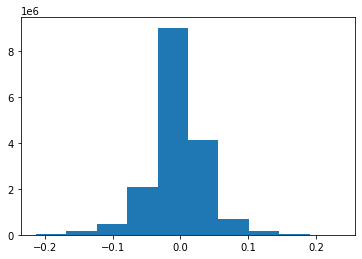

In [68]:
plt.hist(y_test_mean)

In [56]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

In [58]:
train["pred_mean"] = train["MAL_ID"].map(pred_dict)
test["pred_mean"] = test["MAL_ID"].map(pred_test_dict)

<AxesSubplot:>

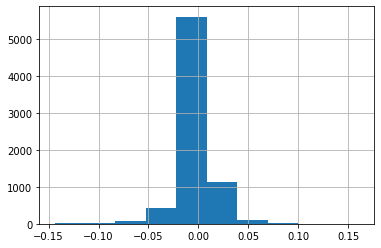

In [64]:
test["pred_mean"].hist()

<AxesSubplot:>

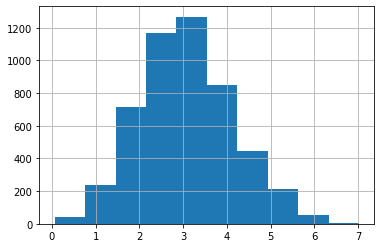

In [65]:
train["pred_mean"].hist()

In [15]:
train_embedding = reduce_mem_usage(train_embedding)
train_embedding.to_feather(SAVE_PATH)

Memory usage of dataframe is 2.37 MB
column =  25
0
Memory usage after optimization is: 1.18 MB
Decreased by 50.0%


In [33]:
user

,user_id,anime_id,rating,watching_status,watched_episodes
0,310366,11009,NaN,6,0
1,321597,4063,NaN,2,12
2,37696,114,9.0,2,26
3,316142,863,0.0,6,0
4,333376,32379,4.0,4,1
...,...,...,...,...,...
26992848,112800,617,NaN,2,1
26992849,34131,16498,NaN,2,25
26992850,110747,3927,8.0,2,25
26992851,94883,37497,NaN,4,6
